<a href="https://www.kaggle.com/code/eltongargantini/temp-timeseries-sp?scriptVersionId=102059291" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from scipy import stats
from sklearn import metrics

#!pip install pmdarima --quiet
#import pmdarima as pm
#pd.plotting.register_matplotlib_converters()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_goiania.csv
/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_manaus.csv
/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_sao_luiz.csv
/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_belem.csv
/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_curitiba.csv
/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_salvador.csv
/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_sao_paulo.csv
/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_macapa.csv
/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_rio.csv
/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_vitoria.csv
/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_recife.csv
/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_fortaleza.csv


# **Import data**

In [2]:
#original data
data = pd.DataFrame(pd.read_csv('/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_sao_paulo.csv'))
data.head()


,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,D-J-F,M-A-M,J-J-A,S-O-N,metANN
0,1946,999.90,999.90,999.90,999.90,999.90,999.90,999.90,999.90,999.90,999.90,999.90,21.74,999.90,999.90,999.90,999.90,999.90
1,1947,999.90,23.54,21.04,19.74,19.24,999.90,15.04,16.44,18.04,17.04,18.94,20.34,22.75,20.01,15.67,18.01,19.11
2,1948,23.64,22.94,20.74,20.04,18.04,16.64,17.84,15.64,18.64,18.74,20.64,21.24,22.31,19.61,16.71,19.34,19.49
3,1949,22.34,21.54,23.54,19.44,17.24,17.34,16.34,17.34,18.24,18.74,19.74,21.54,21.71,20.07,17.01,18.91,19.42
4,1950,22.14,22.44,22.24,20.44,19.44,17.94,16.44,19.14,19.54,19.04,19.94,21.94,22.04,20.71,17.84,19.51,20.02


**Organize database**

In [3]:
#dict with months
months_dict = {'JAN':1,'FEB':2,'MAR':3,'APR':4,'MAY':5,'JUN':6,
               'JUL':7,'AUG':8,'SEP':9,'OCT':10,'NOV':11,'DEC':12}

#create new database with months
data_y_m = data[['YEAR'] + list(months_dict.keys())]

#data transpose
data_y_m = pd.melt(data_y_m, id_vars=['YEAR'], value_vars=list(months_dict.keys()), var_name='MONTH', value_name='TEMP').replace({"MONTH": months_dict})

#create column day equals one
data_y_m['DAY'] = 1
data_y_m.head()

,YEAR,MONTH,TEMP,DAY
0,1946,1,999.90,1
1,1947,1,999.90,1
2,1948,1,23.64,1
3,1949,1,22.34,1
4,1950,1,22.14,1


In [4]:
#create column date
data_y_m['DATE'] = pd.to_datetime(data_y_m[['YEAR', 'MONTH', 'DAY']])

#create new database with only date and temp
data_date = data_y_m[['DATE', 'TEMP']]

#sort and reset index
data_date = data_date.sort_values('DATE').reset_index(drop=True)
data_date.head()

,DATE,TEMP
0,1946-01-01,999.9
1,1946-02-01,999.9
2,1946-03-01,999.9
3,1946-04-01,999.9
4,1946-05-01,999.9


**Explore and visualize data**

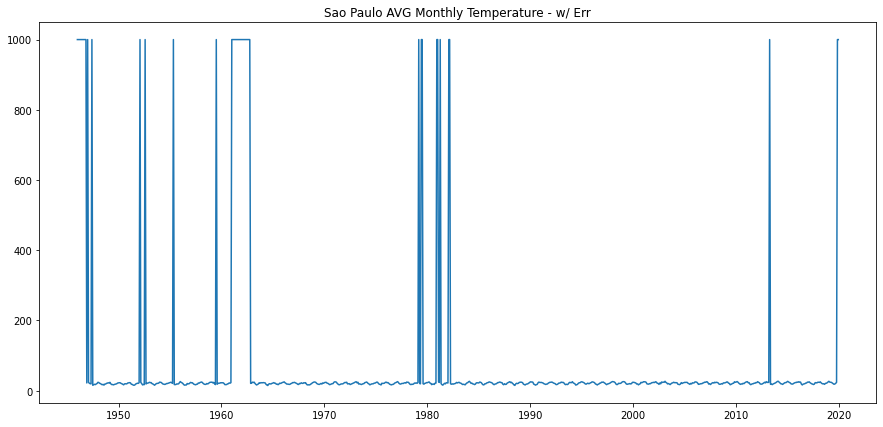

In [5]:
plt.figure(figsize=(15,7))
plt.title("Sao Paulo AVG Monthly Temperature - w/ Err")
plt.plot(data_date['DATE'], data_date['TEMP'])
plt.show(block=False)

In [6]:
print(data_date['TEMP'].value_counts().head())
print(data_date['TEMP'].describe())
print(data_date['DATE'].describe())
print(data_date.shape)

999.90    50
18.74      7
18.94      6
22.34      6
22.24      6
Name: TEMP, dtype: int64
count    888.000000
mean      75.948806
std      225.830385
min       14.520000
25%       18.895000
50%       21.200000
75%       23.235000
max      999.900000
Name: TEMP, dtype: float64
count                     888
unique                    888
top       1946-01-01 00:00:00
freq                        1
first     1946-01-01 00:00:00
last      2019-12-01 00:00:00
Name: DATE, dtype: object
(888, 2)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until


The 999.90 temp has been encountered in 50 dates. Need to take some action to resolve this outlier, in this case drop rows.

In [7]:
#data_date = data_date[(data_date['TEMP'] < 999.9)]
#drop invalid temps
data_date_drop = data_date.loc[(data_date['TEMP'] < 999.9)]

#setting index with dates, drop old column date
data_date_drop = data_date_drop.set_index(data_date_drop['DATE'], drop=True).drop(columns=["DATE"])
data_date_drop.head()

,TEMP
DATE,
1946-12-01,21.74
1947-02-01,23.54
1947-03-01,21.04
1947-04-01,19.74
1947-05-01,19.24


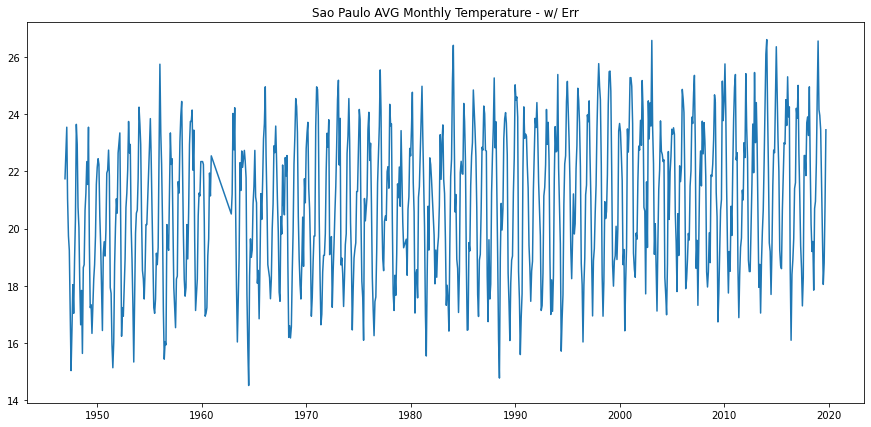

18.74    7
22.54    6
18.24    6
18.94    6
22.24    6
Name: TEMP, dtype: int64
count    838.000000
mean      20.820453
std        2.527936
min       14.520000
25%       18.780000
50%       20.870000
75%       22.797500
max       26.600000
Name: TEMP, dtype: float64
DatetimeIndex(['1946-12-01', '1947-02-01', '1947-03-01', '1947-04-01',
               '1947-05-01', '1947-07-01', '1947-08-01', '1947-09-01',
               '1947-10-01', '1947-11-01',
               ...
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01'],
              dtype='datetime64[ns]', name='DATE', length=838, freq=None)
(838, 1)


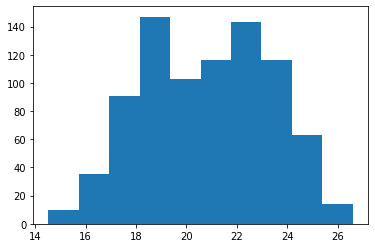

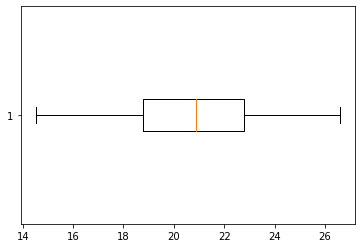

In [8]:
#describe new data

plt.figure(figsize=(15,7))
plt.title("Sao Paulo AVG Monthly Temperature - w/ Err")
plt.plot(data_date_drop.index, data_date_drop.values)
plt.show(block=False)

print(data_date_drop['TEMP'].value_counts().head())
print(data_date_drop['TEMP'].describe())
print(data_date_drop.index)
print(data_date_drop.shape)

plt.hist(data_date_drop['TEMP'].values)
plt.show(block=False)

plt.boxplot(data_date_drop['TEMP'].values, vert=False)
plt.show(block=False)

# **Check stationary (ADF)**

In [9]:
from statsmodels.tsa.stattools import adfuller
X = data_date_drop.TEMP.values
result = adfuller(X)

print('Augmented Dickey-Fuller')
print('ADF statistic: {:.4f}'.format(result[0]))
print('P-value: {:.4f}'.format(result[1]))
print('Critical values:')
for key, value in result[4].items():
    print('\t{}: {:.4f}'.format(key, value))


Augmented Dickey-Fuller
ADF statistic: -3.5934
P-value: 0.0059
Critical values:
	1%: -3.4384
	5%: -2.8651
	10%: -2.5687


The value test (-3.59) is lower than critical value 1% (-3.43) and p-value is lower then 0.05. We can assume that this dataset is stationary (H0 is rejected).

# **Split data**

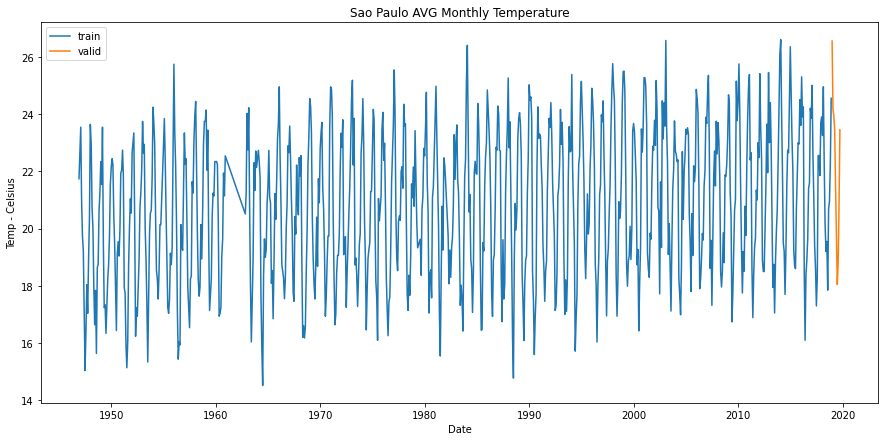

In [10]:
#train, valid = data_date_drop[:int(len(data_date_drop)*0.8)], data_date_drop[int(len(data_date_drop)*0.8):]
#.loc[(data_date['TEMP'] < 999.9)]
train, valid = data_date_drop.loc[(data_date_drop.index<='2018-12-01')],  data_date_drop.loc[(data_date_drop.index>='2019-01-01')]
plt.figure(figsize=(15,7))
plt.title("Sao Paulo AVG Monthly Temperature")
plt.plot(train, label='train')
plt.plot(valid, label='valid')
plt.xlabel('Date')
plt.ylabel('Temp - Celsius')
plt.legend()
plt.show(block=False)

# **Prediction - Using ARIMA**

**ACF and PACF for finding values**

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


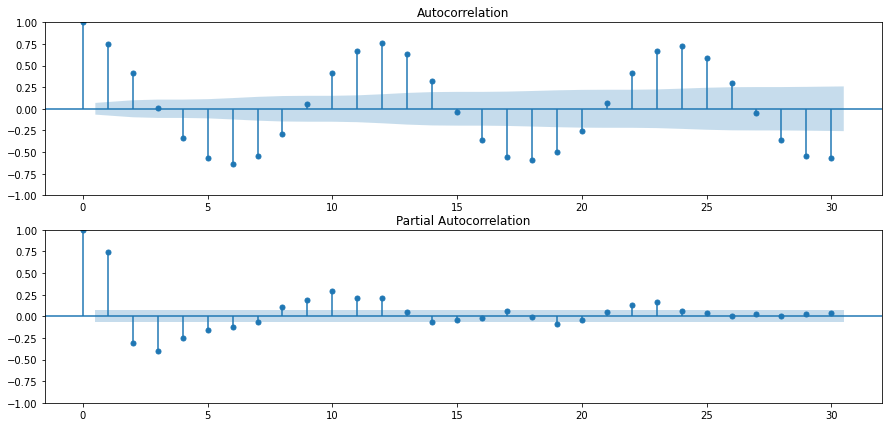

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(15,7))
plt.subplot(211)
plot_acf(data_date_drop, ax=plt.gca())
plt.subplot(212)
plot_pacf(data_date_drop, ax=plt.gca())
plt.show()


PACF lag defines P: 1 or 3 - ACF lag defines Q: 1 or 6

**Function to test models with RMSE and AIC**

In [12]:
from statsmodels.tsa.arima.model import ARIMA
import math

#disable warnings
from warnings import filterwarnings
filterwarnings('ignore')

def model_stats (p, d, q):
    arima_model = ARIMA(train, order = (p, d, q))
    arima_fit = arima_model.fit()
    rmse = math.sqrt(metrics.mean_squared_error(arima_fit.fittedvalues, train.values))
    #print('Model: (',p,',',d,',',q,')')
    #print('RMSE: {:.4f}'.format(rmse))
    #print('AIC: {:.4f}'.format(arima_fit.aic))
    return arima_fit, rmse, arima_fit.aic

**Testing models and finding the best one**

                               SARIMAX Results                                
Dep. Variable:                   TEMP   No. Observations:                  828
Model:               ARIMA(11, 0, 14)   Log Likelihood               -1312.439
Date:                Fri, 29 Jul 2022   AIC                           2678.877
Time:                        16:23:39   BIC                           2806.291
Sample:                             0   HQIC                          2727.744
                                - 828                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.7831      0.902     23.036      0.000      19.015      22.551
ar.L1          1.1217      0.783      1.433      0.152      -0.413       2.656
ar.L2         -0.3340      1.466     -0.228      0.8

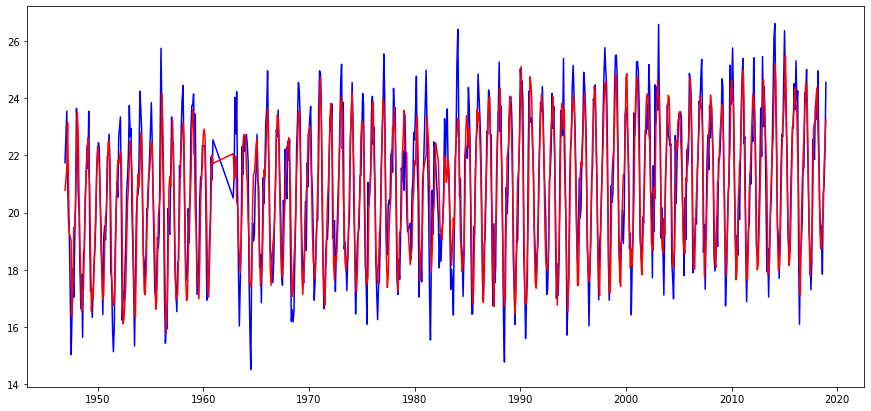

In [13]:
#testing some models
#best models with d=0, ARMA

'''
#around 4 hours to find the best model
#function to find optimum stats

for p in range(21):
    for d in range(1):
        for q in range(21):
            if p==0 and d==0 and q==0:
                best_arima_fit, best_model_rmse, best_model_aic = model_stats(p, d, q)
            else:
                arima_fit, model_rmse, model_aic = model_stats(p, d, q)
                
                if model_rmse < best_model_rmse and model_aic < best_model_aic:
                    best_arima_fit, best_model_rmse, best_model_aic = arima_fit, model_rmse, model_aic

'''

''' 
#around 5 minutes to execute, not the best model but find a considerable one

p=0
d=0
q=0

for p_i in range(21):    
    if p_i==0 and d==0 and q==0:
        best_arima_fit, best_model_rmse, best_model_aic = model_stats(p_i, d, q)
        p = p_i
    else:
        arima_fit, model_rmse, model_aic = model_stats(p_i, d, q)

        if model_rmse < best_model_rmse and model_aic < best_model_aic:
            best_arima_fit, best_model_rmse, best_model_aic = arima_fit, model_rmse, model_aic
            p = p_i
        

for d_i in range(1):
    if p==0 and d_i==0 and q==0:
        best_arima_fit, best_model_rmse, best_model_aic = model_stats(p, d_i, q)
        d = d_i
    else:
        arima_fit, model_rmse, model_aic = model_stats(p, d_i, q)

        if model_rmse < best_model_rmse and model_aic < best_model_aic:
            best_arima_fit, best_model_rmse, best_model_aic = arima_fit, model_rmse, model_aic
            d = d_i
    
for q_i in range(21):
    if p==0 and d==0 and q_i==0:
        best_arima_fit, best_model_rmse, best_model_aic = model_stats(p, d, q_i)
        q = q_i
    else:
        arima_fit, model_rmse, model_aic = model_stats(p, d, q_i)

        if model_rmse < best_model_rmse and model_aic < best_model_aic:
            best_arima_fit, best_model_rmse, best_model_aic = arima_fit, model_rmse, model_aic
            q = q_i
            
'''

#best model at all, finding in the first loop, rmse forecasting 1.2406
best_arima_fit, best_model_rmse, best_model_aic = model_stats(11, 0, 14)
print(best_arima_fit.summary())
print('RMSE: {:.4f}'.format(best_model_rmse))

#best model on the second loop, rmse forecasting 1.2458
#best_arima_fit, best_model_rmse, best_model_aic = model_stats(19, 0, 13)
#print(best_arima_fit.summary())
#print('RMSE: {:.4f}'.format(best_model_rmse))

plt.figure(figsize=(15,7))
plt.plot(train, color='blue')
plt.plot(best_arima_fit.fittedvalues, color = 'red')

**Forecasting**

Forecasting x Valid - 2019
RMSE: 1.2406


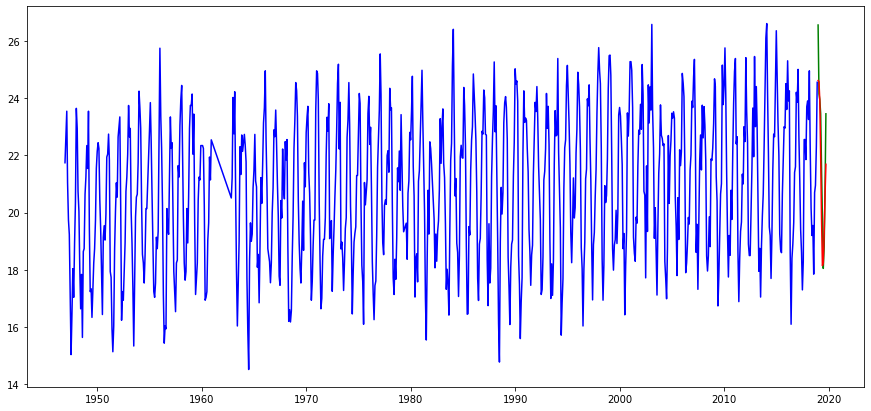

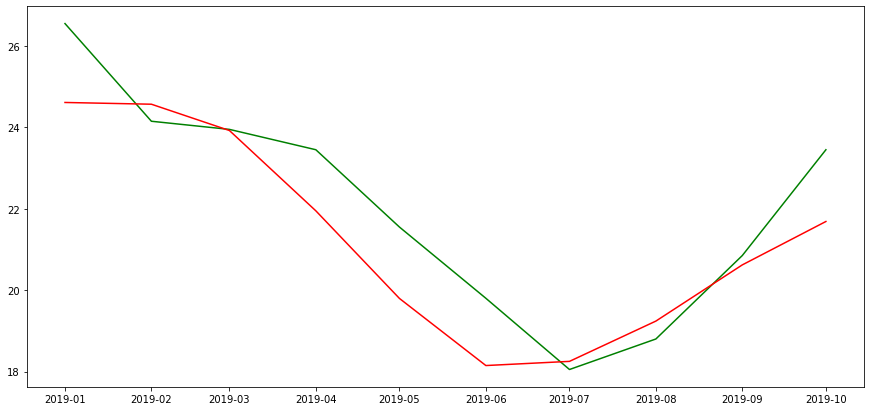

Forecasting 2019~2020


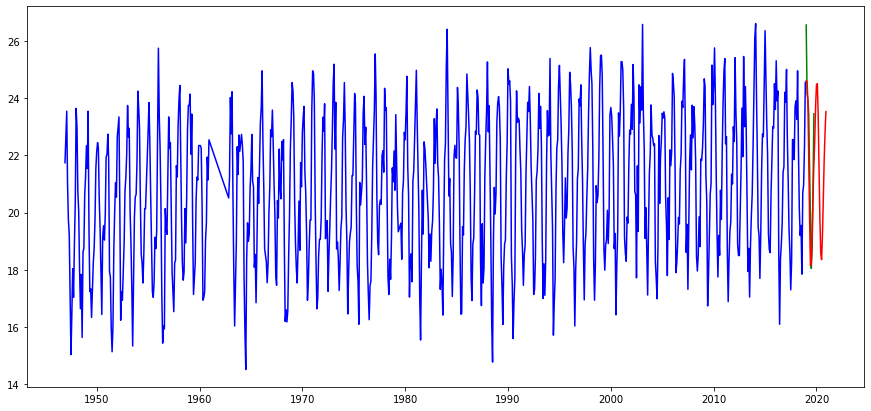

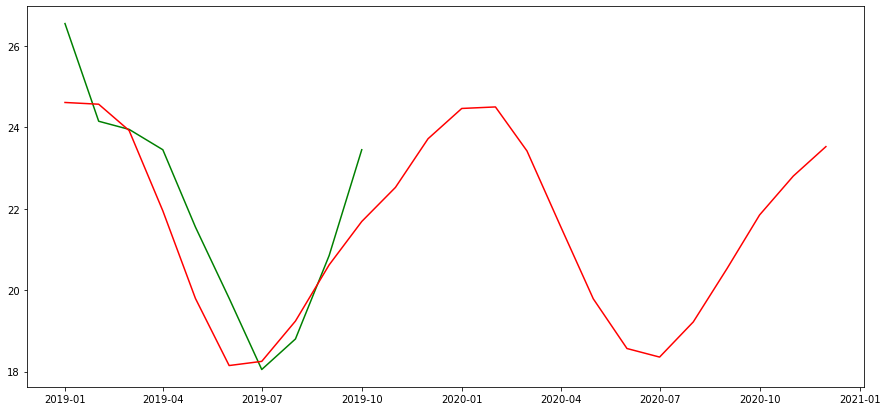

In [14]:
last_date = pd.to_datetime(train.index[len(train) - 1])

fc = best_arima_fit.forecast(10, alpha=0.05)

forecast_index = []
for i in range(len(fc)):
    next_date = last_date + pd.DateOffset(months = 1)
    forecast_index.append(next_date)
    last_date = next_date
forecast_series = pd.Series(data = fc.values, index = forecast_index)

print('Forecasting x Valid - 2019')
rmse = math.sqrt(metrics.mean_squared_error(forecast_series.values, valid.values))
print('RMSE: {:.4f}'.format(rmse))

plt.figure(figsize=(15,7))
plt.plot(train, color='blue')
plt.plot(valid, color='green')
plt.plot(forecast_series, color='red')

plt.figure(figsize=(15,7))
plt.plot(valid, color='green')
plt.plot(forecast_series, color='red')
plt.show(block=False)

#24 meses
last_date = pd.to_datetime(train.index[len(train) - 1])
fc = best_arima_fit.forecast(24, alpha=0.05)

forecast_index = []
for i in range(len(fc)):
    next_date = last_date + pd.DateOffset(months = 1)
    forecast_index.append(next_date)
    last_date = next_date
forecast_series = pd.Series(data = fc.values, index = forecast_index)

print('Forecasting 2019~2020')

plt.figure(figsize=(15,7))
plt.plot(train, color='blue')
plt.plot(valid, color='green')
plt.plot(forecast_series, color='red')

plt.figure(figsize=(15,7))
plt.plot(valid, color='green')
plt.plot(forecast_series, color='red')
plt.show(block=False)


# **Predict using SARIMA**

Now, test some SARIMA models to compare with ARIMA.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80839D+00    |proj g|=  1.59517D-01


 This problem is unconstrained.



At iterate    5    f=  1.78191D+00    |proj g|=  2.01737D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   7.965D-08   1.782D+00
  F =   1.7819116848189893     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RMSE: 1.7190


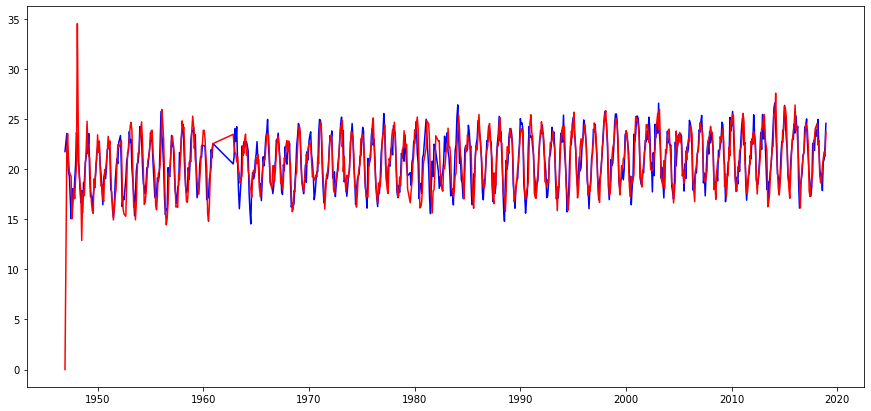

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               TEMP   No. Observations:                  828
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1475.423
Date:                            Fri, 29 Jul 2022   AIC                           2956.846
Time:                                    16:23:42   BIC                           2970.955
Sample:                                         0   HQIC                          2962.261
                                            - 828                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3884      0.029    -13.439      0.000      -0.445      -0.332
ma.S.L12      -0.6370      0.026    -24.262      0.000      -0.688      -0.586
sigma2         2.1704      0.100     21.652      0.000       1.974       2.367
===================================================================================
Ljung-Box (L1) (Q):                   2.08   Jarque-Bera (JB):                 8.20
Prob(Q):                              0.15   Prob(JB):                         0.02
Heteroskedasticity (H):               0.82   Skew:                            -0.04
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
    from statsmodels.tsa.statespace.sarimax import SARIMAX

'''
sarima_model = SARIMAX(train,
                       order = (6, 1, 1), 
                        seasonal_order = (0, 1, 2, 12))
'''

sarima_model = SARIMAX(train,
                       order = (0, 1, 1), 
                        seasonal_order = (0, 1, 1, 12))

sarima_fit = sarima_model.fit()
#print(arima_fit.summary())

rmse = math.sqrt(metrics.mean_squared_error(sarima_fit.fittedvalues, train.values))

print('RMSE: {:.4f}'.format(rmse))

plt.figure(figsize=(15,7))
plt.plot(train, color='blue')
plt.plot(sarima_fit.fittedvalues, color = 'red')
plt.show(block=False)

sarima_fit.summary()

Forecasting x Valid - 2019
RMSE: 1.0518


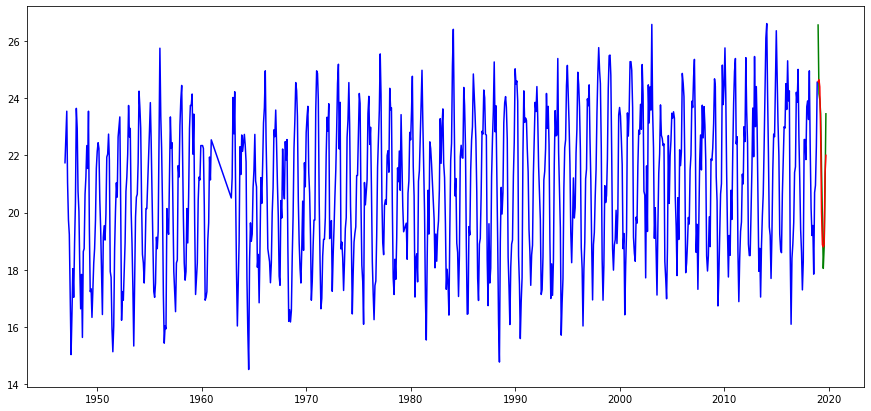

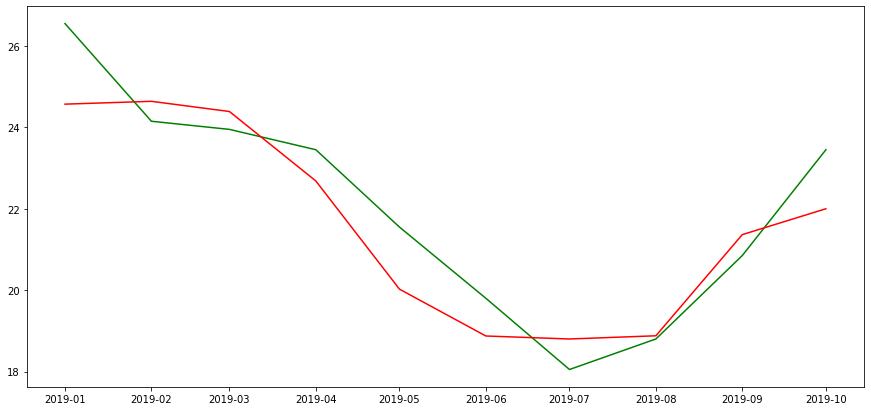

Forecasting 2019~2020


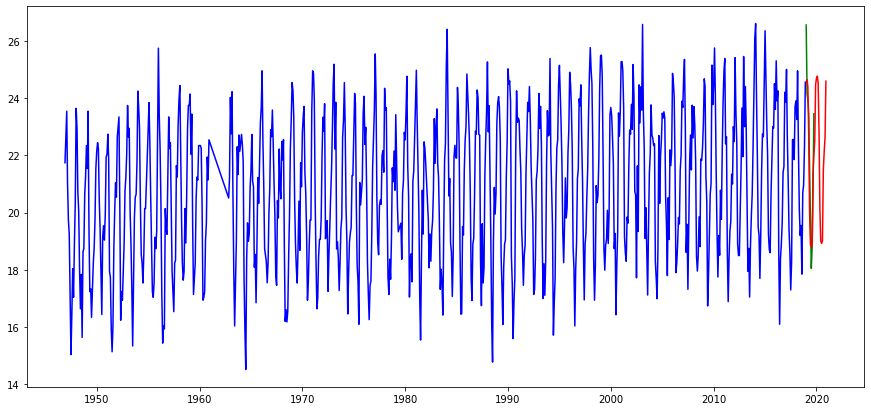

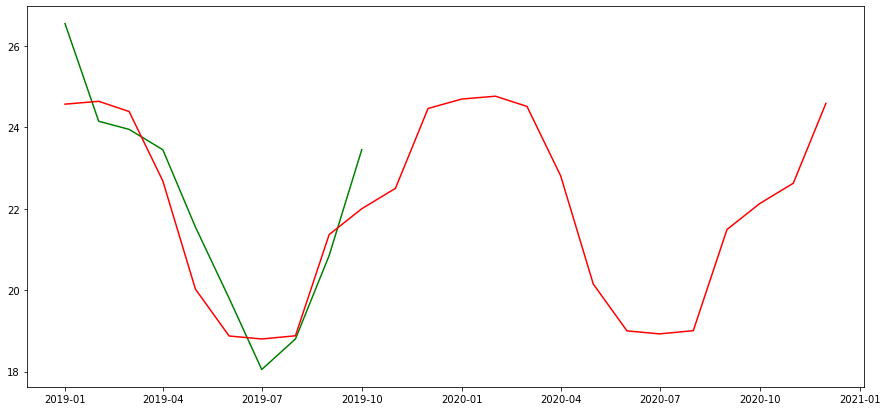

In [16]:
last_date = pd.to_datetime(train.index[len(train) - 1])

fc = sarima_fit.forecast(10, alpha=0.05)

forecast_index = []
for i in range(len(fc)):
    next_date = last_date + pd.DateOffset(months = 1)
    forecast_index.append(next_date)
    last_date = next_date
forecast_series = pd.Series(data = fc.values, index = forecast_index)

print('Forecasting x Valid - 2019')
rmse = math.sqrt(metrics.mean_squared_error(forecast_series.values, valid.values))
print('RMSE: {:.4f}'.format(rmse))

plt.figure(figsize=(15,7))
plt.plot(train, color='blue')
plt.plot(valid, color='green')
plt.plot(forecast_series, color='red')

plt.figure(figsize=(15,7))
plt.plot(valid, color='green')
plt.plot(forecast_series, color='red')
plt.show(block=False)

#24 meses
last_date = pd.to_datetime(train.index[len(train) - 1])
fc = sarima_fit.forecast(24, alpha=0.05)

forecast_index = []
for i in range(len(fc)):
    next_date = last_date + pd.DateOffset(months = 1)
    forecast_index.append(next_date)
    last_date = next_date
forecast_series = pd.Series(data = fc.values, index = forecast_index)

print('Forecasting 2019~2020')

plt.figure(figsize=(15,7))
plt.plot(train, color='blue')
plt.plot(valid, color='green')
plt.plot(forecast_series, color='red')

plt.figure(figsize=(15,7))
plt.plot(valid, color='green')
plt.plot(forecast_series, color='red')
plt.show(block=False)
#sarima_fit.plot_diagnostics(figsize=(15,12))

https://www.kaggle.com/code/brendanartley/time-series-forecasting-prediction-intervals
https://colab.research.google.com/drive/1PmFbbs_K69WqvOIEjoo3yt691Hnj4st7
https://medium.com/techbloghotmart/dicas-para-criar-um-modelo-de-previs%C3%A3o-de-s%C3%A9ries-temporais-d4bb2e32e148
https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/
https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6
https://people.duke.edu/~rnau/411home.htm
https://medium.com/techbloghotmart/o-que-s%C3%A3o-s%C3%A9ries-temporais-e-como-aplicar-em-machine-learning-6ea5d94bec78
https://medium.com/@gabriellimadduarte/predi%C3%A7%C3%A3o-de-series-temporais-arima-54c54b8dccec
